In this notebook, we can explore the data a bit more thoroughly. We load all precomputed datasets and can make several plots.
- We can check the percentages per allele,site for each cell.
- We can check the allele counts per allele,site for each cell.
- We can make heatmaps with allele/sites on the x-axis and cells on the y-axis. Every colour represents a different scar. This gives a nice overview of the complexity of the data, the fraction of WT sequences and the amount of missing data.
- We can cluster the cells based on their scar profile using IWSS.
- We can plot clusters of cells with similar scar profiles on top of the transciptome umap to see which cell types are found in which clusters.

# Import all relevant packages

In [1]:
#import all 
%matplotlib inline
import matplotlib
from pandas.io.parsers import read_csv
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import collections
import scipy
import itertools

import scanpy as sc
dpi = 50
sc.set_figure_params(dpi=dpi, color_map = 'viridis')

# Load computed datasets

#### Here you can load all precomputed datasets.

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20201001_FACS5_scGastruloid_VAN5043/'

In [3]:
df = pd.read_pickle(pathToData + 'dataframes/FACS5_120hAA_VAN5043_filtered.pickle.gz')
df.head()

gastruloid                   B11                                           \
cell                        A1_1 A1_10 A1_100 A1_101 A1_102 A1_103 A1_104   
chrom allele site      scar                                                 
1     None   115876167 WT    NaN   NaN    NaN    NaN    NaN    NaN    NaN   
             83738341  WT    NaN   NaN    NaN    NaN    NaN    NaN    NaN   
             91213028  WT    NaN   NaN    NaN    NaN    NaN    NaN    NaN   
10    None   121763233 WT    NaN   NaN    NaN    NaN    NaN    NaN    NaN   
             19868967  WT    NaN   NaN    NaN    NaN    NaN    NaN    NaN   

gastruloid                                        ...    C1                    \
cell                        A1_105 A1_106 A1_107  ... A2_90 A2_91 A2_92 A2_93   
chrom allele site      scar                       ...                           
1     None   115876167 WT      NaN    NaN    NaN  ...   NaN   NaN   NaN   NaN   
             83738341  WT      NaN    NaN    NaN  ...   NaN   NaN   NaN   NaN   
             91213028  WT      NaN    NaN    NaN  ...   NaN   NaN   NaN   NaN   
10    None   121763233 WT      NaN    NaN    NaN  ...   NaN   NaN   NaN   NaN   
             19868967  WT      NaN    NaN    NaN  ...   NaN   NaN   NaN   NaN   

gastruloid                                                       
cell                        A2_94 A2_95 A2_96 A2_97 A2_98 A2_99  
chrom allele site      scar                                      
1     None   115876167 WT     NaN   NaN   NaN   NaN   NaN   NaN  
             83738341  WT     NaN   NaN   NaN   NaN   NaN   NaN  
             91213028  WT     NaN   NaN   NaN   NaN   NaN   NaN  
10    None   121763233 WT     NaN   NaN   NaN   NaN   NaN   NaN  
             19868967  WT     NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 4551 columns]

In [4]:
sf = df.loc['12']

sf_129 = sf.loc['129S1_SvImJ']
sf_B6 = sf.loc['C57BL_6NJ']

sf_nonallelic = sf.loc['None']



In [5]:
#calculate total amount of reads per site
sums_cells_all = pd.DataFrame(sf.sum(axis=0, level=1).sum(axis=1))

#calculate total amount of reads per site, allele-specific
sums_cells_129 = pd.DataFrame(sf_129.sum(axis=0, level=0).sum(axis=1))
sums_cells_B6 = pd.DataFrame(sf_B6.sum(axis=0, level=0).sum(axis=1))
sums_cells_nonallelic = pd.DataFrame(sf_nonallelic.sum(axis=0, level=0).sum(axis=1))

#merge
countspersite = pd.concat([sums_cells_B6,sums_cells_129,
                                  sums_cells_nonallelic, sums_cells_all], axis=1, sort=True)
countspersite.columns = ['B6', '129', 'NA', 'all']
countspersite = countspersite.fillna(0)




/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_40606/1274583506.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sums_cells_all = pd.DataFrame(sf.sum(axis=0, level=1).sum(axis=1))
/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_40606/1274583506.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sums_cells_129 = pd.DataFrame(sf_129.sum(axis=0, level=0).sum(axis=1))
/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_40606/1274583506.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).s

In [6]:
targetsites = ['114682729', '14708745', '114723869', '114740505','114746370', '114788469', '114843748', '114851287',
          '114879985','114896335','114910108','114914696']

selectedTargetSites = []
for site in targetsites:
    if site in countspersite.index:
        selectedTargetSites.append(site)
        
#select only scar sites
selectedSites = countspersite.loc[selectedTargetSites]

#selectedSites = countspersite.sort_values(by='all',ascending=False)[0:10]





In [7]:
#calculate total amount of reads per site
sums_cells_all = pd.DataFrame(sf.sum(axis=0, level=1).sum(axis=1))

#calculate total amount of reads per site, allele-specific
sums_cells_129 = pd.DataFrame(sf_129.sum(axis=0, level=0).sum(axis=1))
sums_cells_B6 = pd.DataFrame(sf_B6.sum(axis=0, level=0).sum(axis=1))
sums_cells_nonallelic = pd.DataFrame(sf_nonallelic.sum(axis=0, level=0).sum(axis=1))

#merge
countspersite = pd.concat([sums_cells_B6,sums_cells_129,
                                  sums_cells_nonallelic, sums_cells_all], axis=1, sort=True)
countspersite.columns = ['B6', '129', 'NA', 'all']
countspersite = countspersite.fillna(0)

# select scar target sites that survived all filtering steps:
#selectedSites = countspersite.sort_values(by='all',ascending=False)[0:10]



/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_40606/3878664950.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sums_cells_all = pd.DataFrame(sf.sum(axis=0, level=1).sum(axis=1))
/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_40606/3878664950.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sums_cells_129 = pd.DataFrame(sf_129.sum(axis=0, level=0).sum(axis=1))
/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_40606/3878664950.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).s

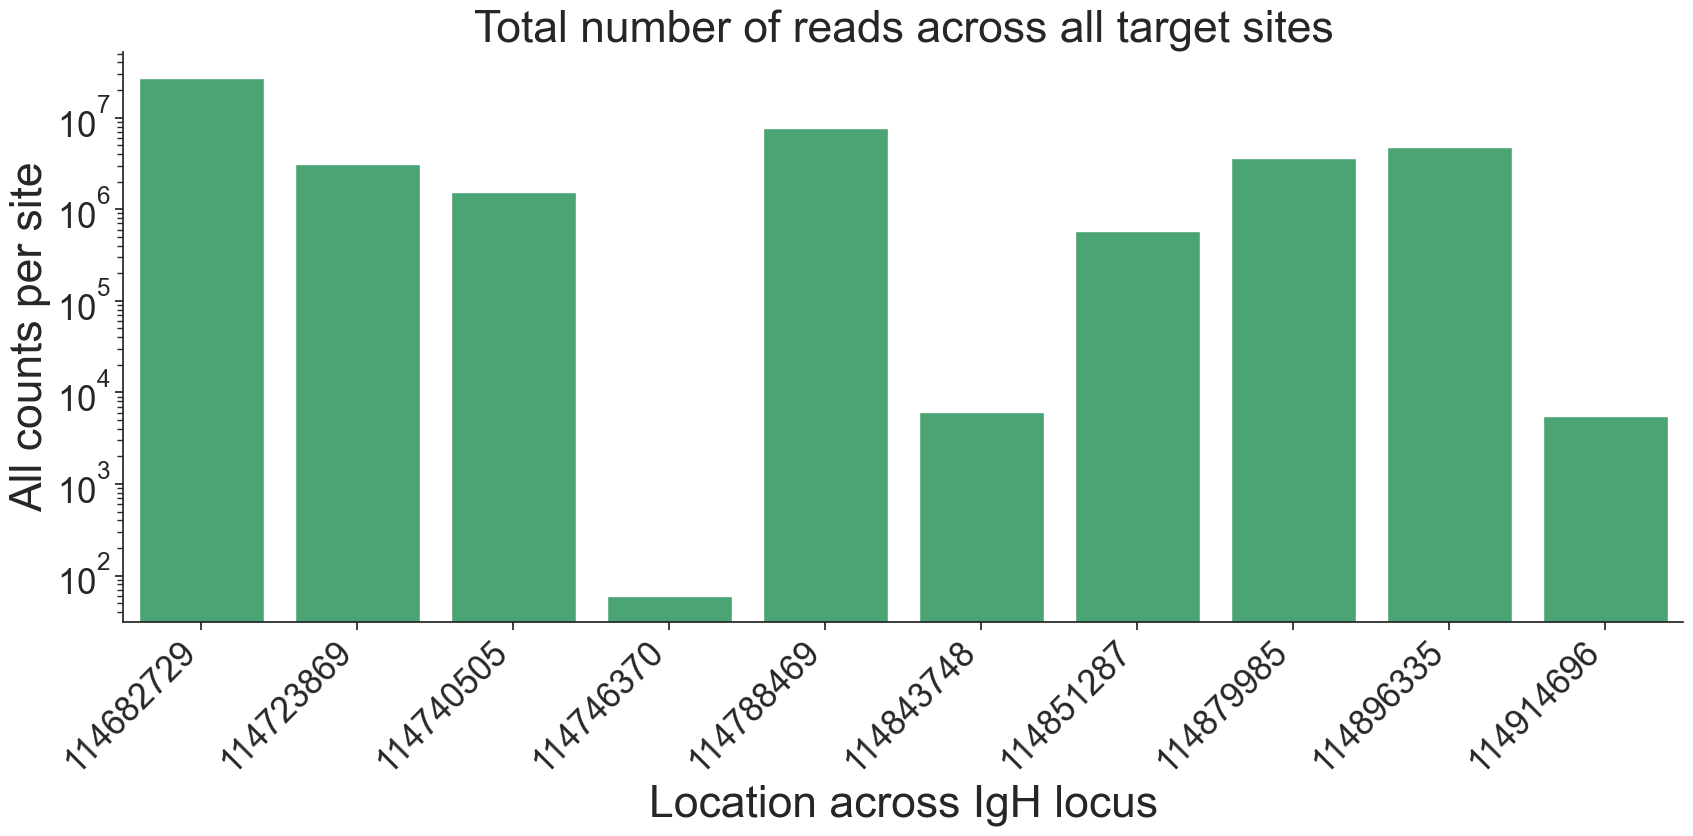

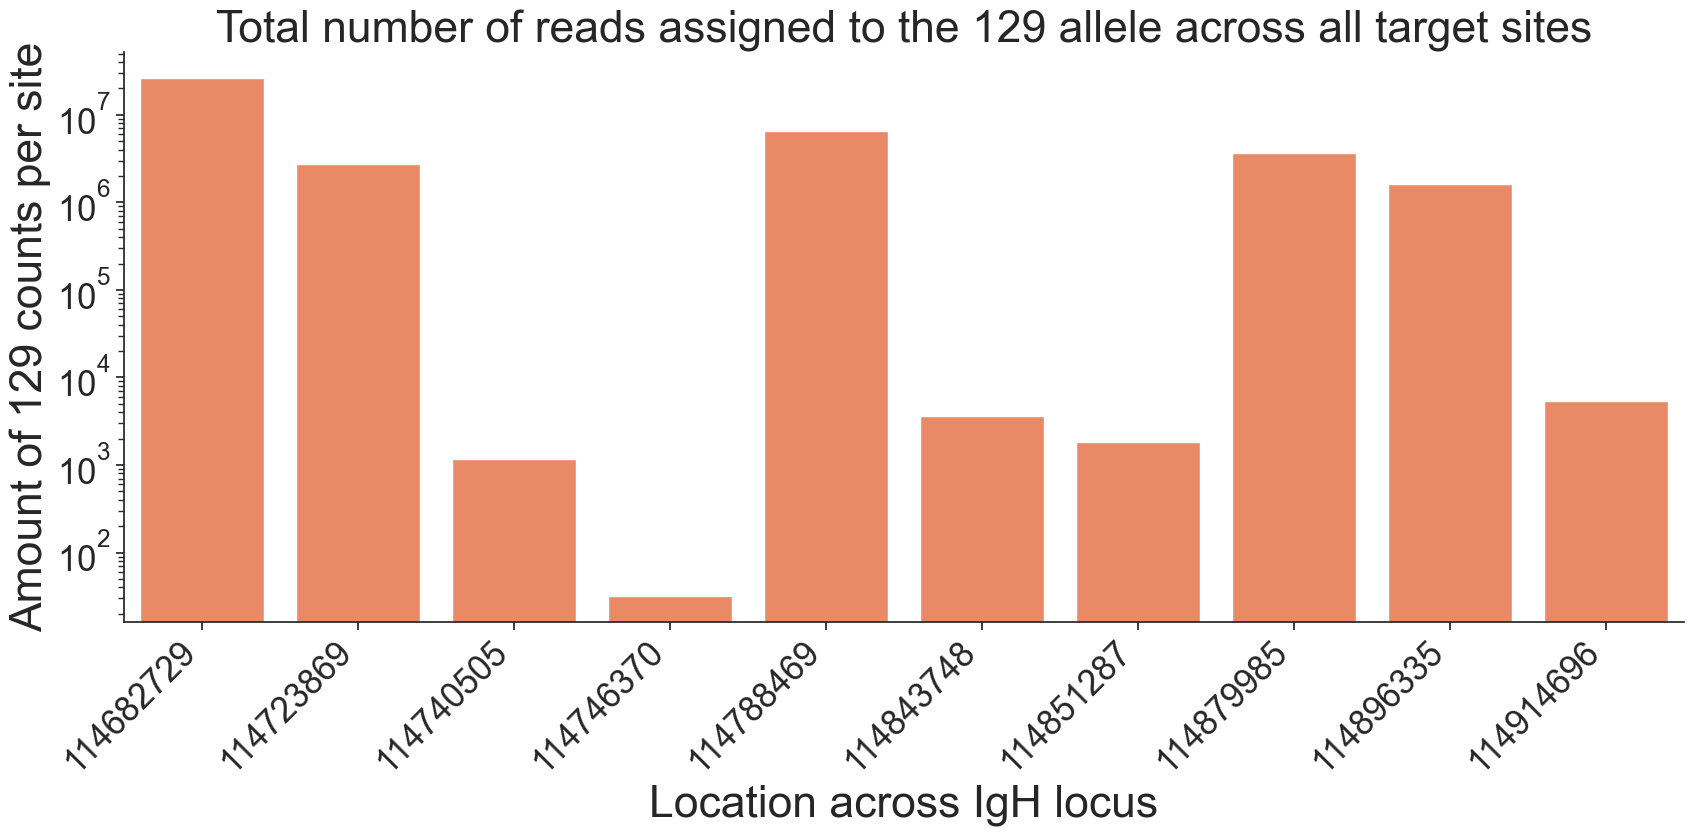

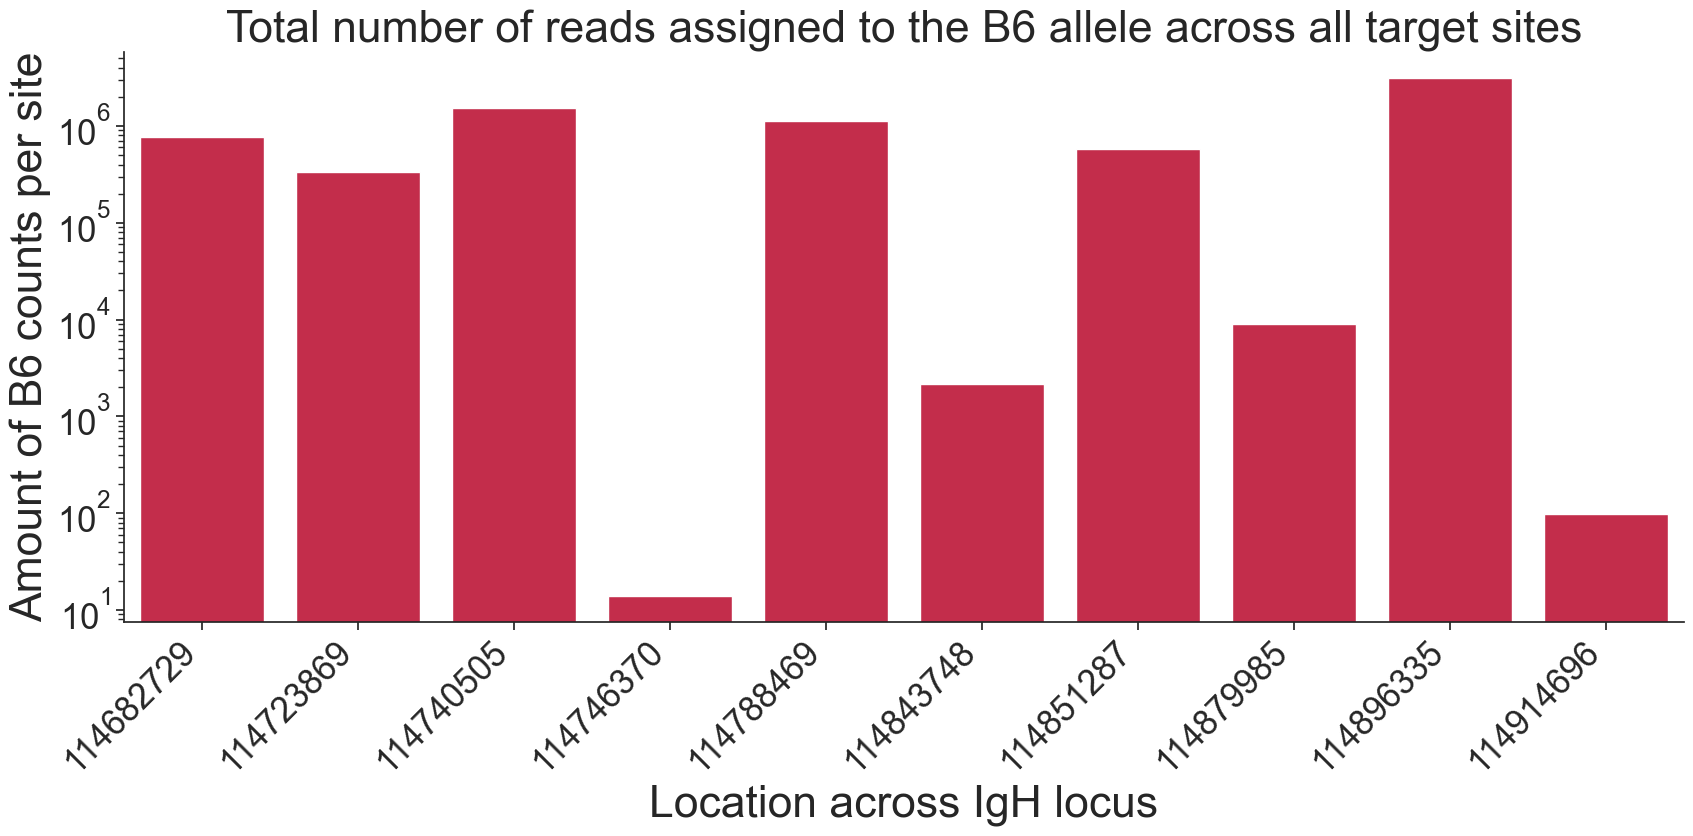

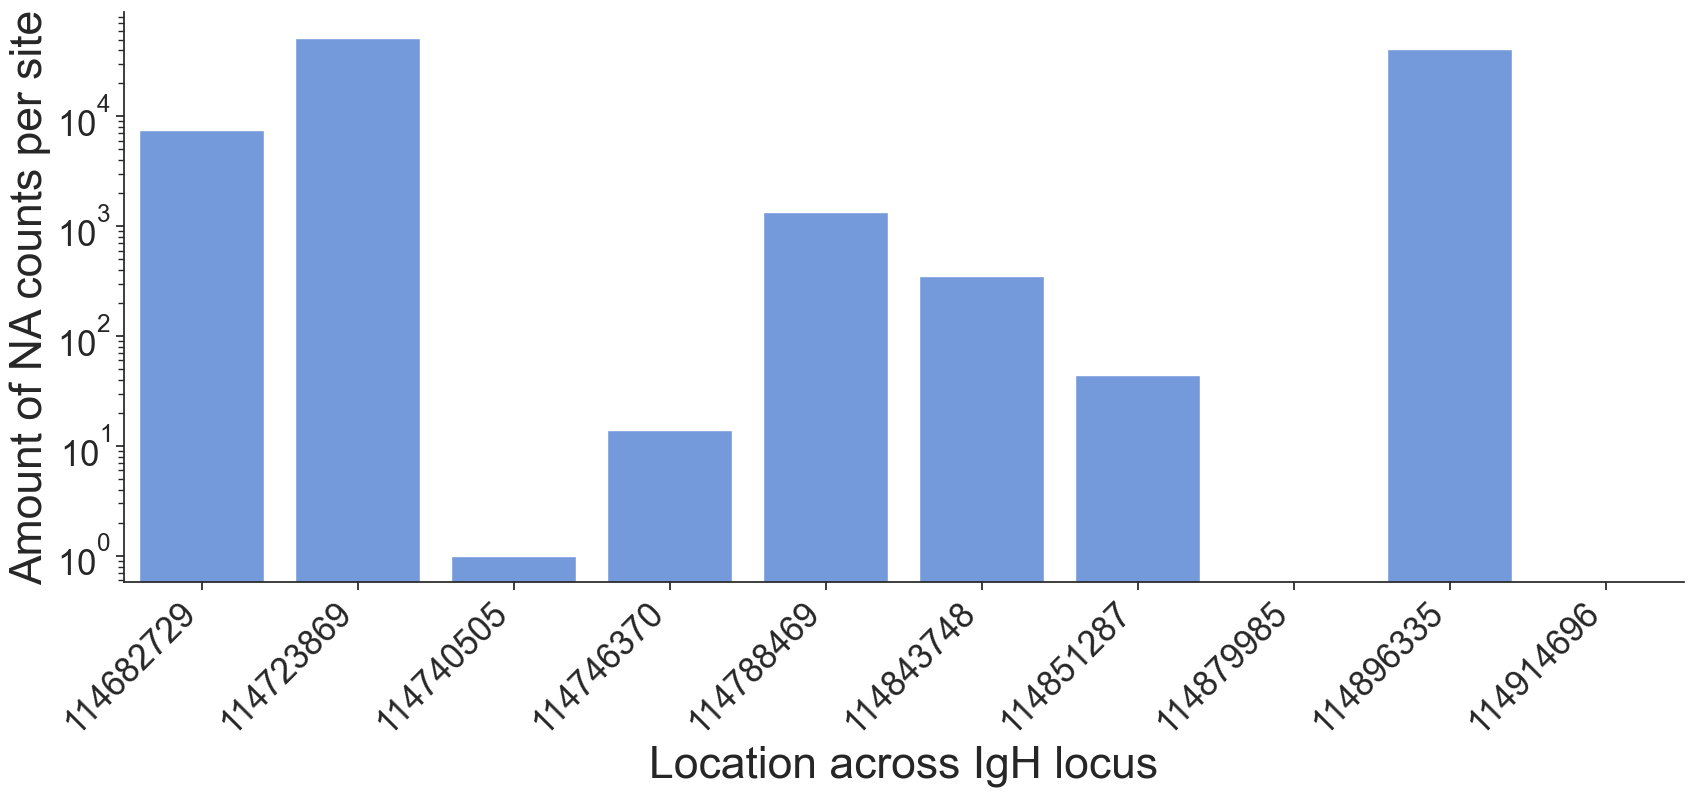

In [8]:
#plots
sc.set_figure_params(dpi=dpi, color_map = 'viridis')

sns.set(style="ticks")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['all'], log='y', color='mediumseagreen')
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('All counts per site', fontsize=32)
ax.tick_params(labelsize=25)
ax.tick_params(axis = 'x',rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.title('Total number of reads across all target sites', fontsize = 32)
sns.despine()
plt.show()

plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['129'], log='y', color='coral')
ax.tick_params(labelsize=25)
ax.tick_params(axis = 'x',rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of 129 counts per site', fontsize=32)
plt.title('Total number of reads assigned to the 129 allele across all target sites', fontsize = 32)
sns.despine()
plt.show()

plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['B6'], log='y', color='crimson')
ax.tick_params(labelsize=25)
ax.tick_params(axis = 'x',rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of B6 counts per site', fontsize=32)
plt.title('Total number of reads assigned to the B6 allele across all target sites', fontsize = 32)
sns.despine()
plt.show()

plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedSites.index, y=selectedSites['NA'], log='y', color='cornflowerblue')
ax.tick_params(labelsize=25)
ax.tick_params(axis = 'x',rotation=45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of NA counts per site', fontsize=32)
sns.despine()
plt.show()

In [9]:
#to load dataframes containing all calculated percentages again
percentagesChr12_129 = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6 = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataFramepercentagesChr12_NA.pickle.gz')

In [10]:
#to load dataframes containing all allele counts again
alleleCountsChr12_129PD = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataFrameAlleleCountsChr12_129.pickle.gz')
alleleCountsChr12_B6PD = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataFrameAlleleCountsChr12_B6.pickle.gz')
alleleCountsChr12_NAPD = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataFrameAlleleCountsChr12_NA.pickle.gz')

In [11]:
#to load dataframes for distance calculation again
all_allelecounts_fordistancecalc = pd.read_pickle(pathToData + 'dataframes/VAN5043_all_allelecounts_fordistancecalc.pickle.gz')
allelecountsNA_ts = pd.read_pickle(pathToData + 'dataframes/VAN5043_allelecountsNA_ts.pickle.gz')
allelecountsB6_ts = pd.read_pickle(pathToData + 'dataframes/VAN5043_allelecountsB6_ts.pickle.gz')
allelecounts129_ts = pd.read_pickle(pathToData + 'dataframes/VAN5043_allelecounts129_ts.pickle.gz')

In [12]:
#to load dataframes for Buys' heatmap calculation again
heatmap_129 = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataframeForHeatmap_All_129.pickle.gz')
heatmap_129.index.names = ['gastruloid', 'cell']
heatmap_B6 = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataframeForHeatmap_All_B6.pickle.gz')
heatmap_B6.index.names = ['gastruloid', 'cell']
heatmap_NA = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataframeForHeatmap_All_nonallelic.pickle.gz')
heatmap_NA.index.names = ['gastruloid', 'cell']

heatmap = pd.read_pickle(pathToData + 'dataframes/VAN5043_dataframeForHeatmap_All.pickle.gz')
heatmap.index.names = ['gastruloid', 'cell']

In [13]:
cols=["black", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D","#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176","#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5","#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4","#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01","#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966","#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0","#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C","#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868","#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183","#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433","#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F","#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E","#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F","#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00","#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66","#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25","#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948","#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5","#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C","#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8","#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055","#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D","#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8","#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1","#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3","#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0","#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143","#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196","#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27","#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF","#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941","#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0","#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5","#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59","#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2","#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0","#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874","#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00","#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA","#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636","#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01","#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72","#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E","#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9","#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B","#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451","#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61","#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C","#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B","#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A","#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133","#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00","#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590","#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899","#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F","#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B","#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52","#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8","#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95","#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E","#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D","#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00","#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690","#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7","#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D","#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800","#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262","#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00","#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77","#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62","#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E","#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917","#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5","#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452","#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE","#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E","#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E","#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C","#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A","#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183","#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891","#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83","#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48","#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601","#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268","#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF","#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A","#AF756F", "#2A2000", "#7499A1", "#FFB550", "#00011E", "#D1511C", "#688151", "#BC908A","#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715", "#0CEA91", "#FFFAED","#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C", "#00768B", "#337D00","#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C", "#4C257F", "#9E0366","#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195", "#A9795C", "#E4C5D3","#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487", "#C23000", "#ABE86B","#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61", "#A449DC", "#6A9D3B","#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4", "#FFDED6", "#6C6D74","#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53", "#AC84DD", "#762988","#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B", "#2F2E2C", "#023C32","#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD", "#834357", "#1A7B42","#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC", "#F35691", "#D7C54A","#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3", "#5F816D", "#3A404A","#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00", "#4B5D56", "#6B543F","#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021", "#2D2011", "#DA4CFF","#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486", "#1F263C", "#36574E","#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B", "#CCD27F", "#94A5A1","#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70", "#314C1E", "#874AA6","#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180", "#B8552F", "#1A2B2F","#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E", "#CCE93A", "#917100","#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776", "#4692AD", "#67BDA8","#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC", "#51A288", "#2C656A","#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69", "#858182", "#D4E9B9","#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]

#  Plotting percentages

Plot percentages of scars per cell for one site and all cells of one gastruloid

In [14]:
def plotPercentagesAllele129(gastruloid, site):
    
    fontsize = 24
    
    percentagepersite = []
    for cell in percentagesChr12_129[gastruloid]:
        percentagepersite.append(percentagesChr12_129[gastruloid][cell][site].dropna())
    
    percentagepersitepd = pd.DataFrame(percentagepersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(percentagepersitepd.fillna(0)))
    orderedpercentagepersitepd = percentagepersitepd.iloc[order]
    ax = orderedpercentagepersitepd.plot.bar(stacked=True,figsize=(12,4),fontsize = 15,width=0.90, color=cols)
    ax.set_xlabel("Cells",fontsize=fontsize)
    ax.set_title(('FILTERED: Site ' + str(site) + ', gastruloid' + gastruloid + ', allele 129'), fontsize=fontsize)
    ax.set_ylabel("Percentage",fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend([],frameon=False)
    sns.despine()
    #ax.legend(bbox_to_anchor=(0.9,-0.1))
    return ax


    

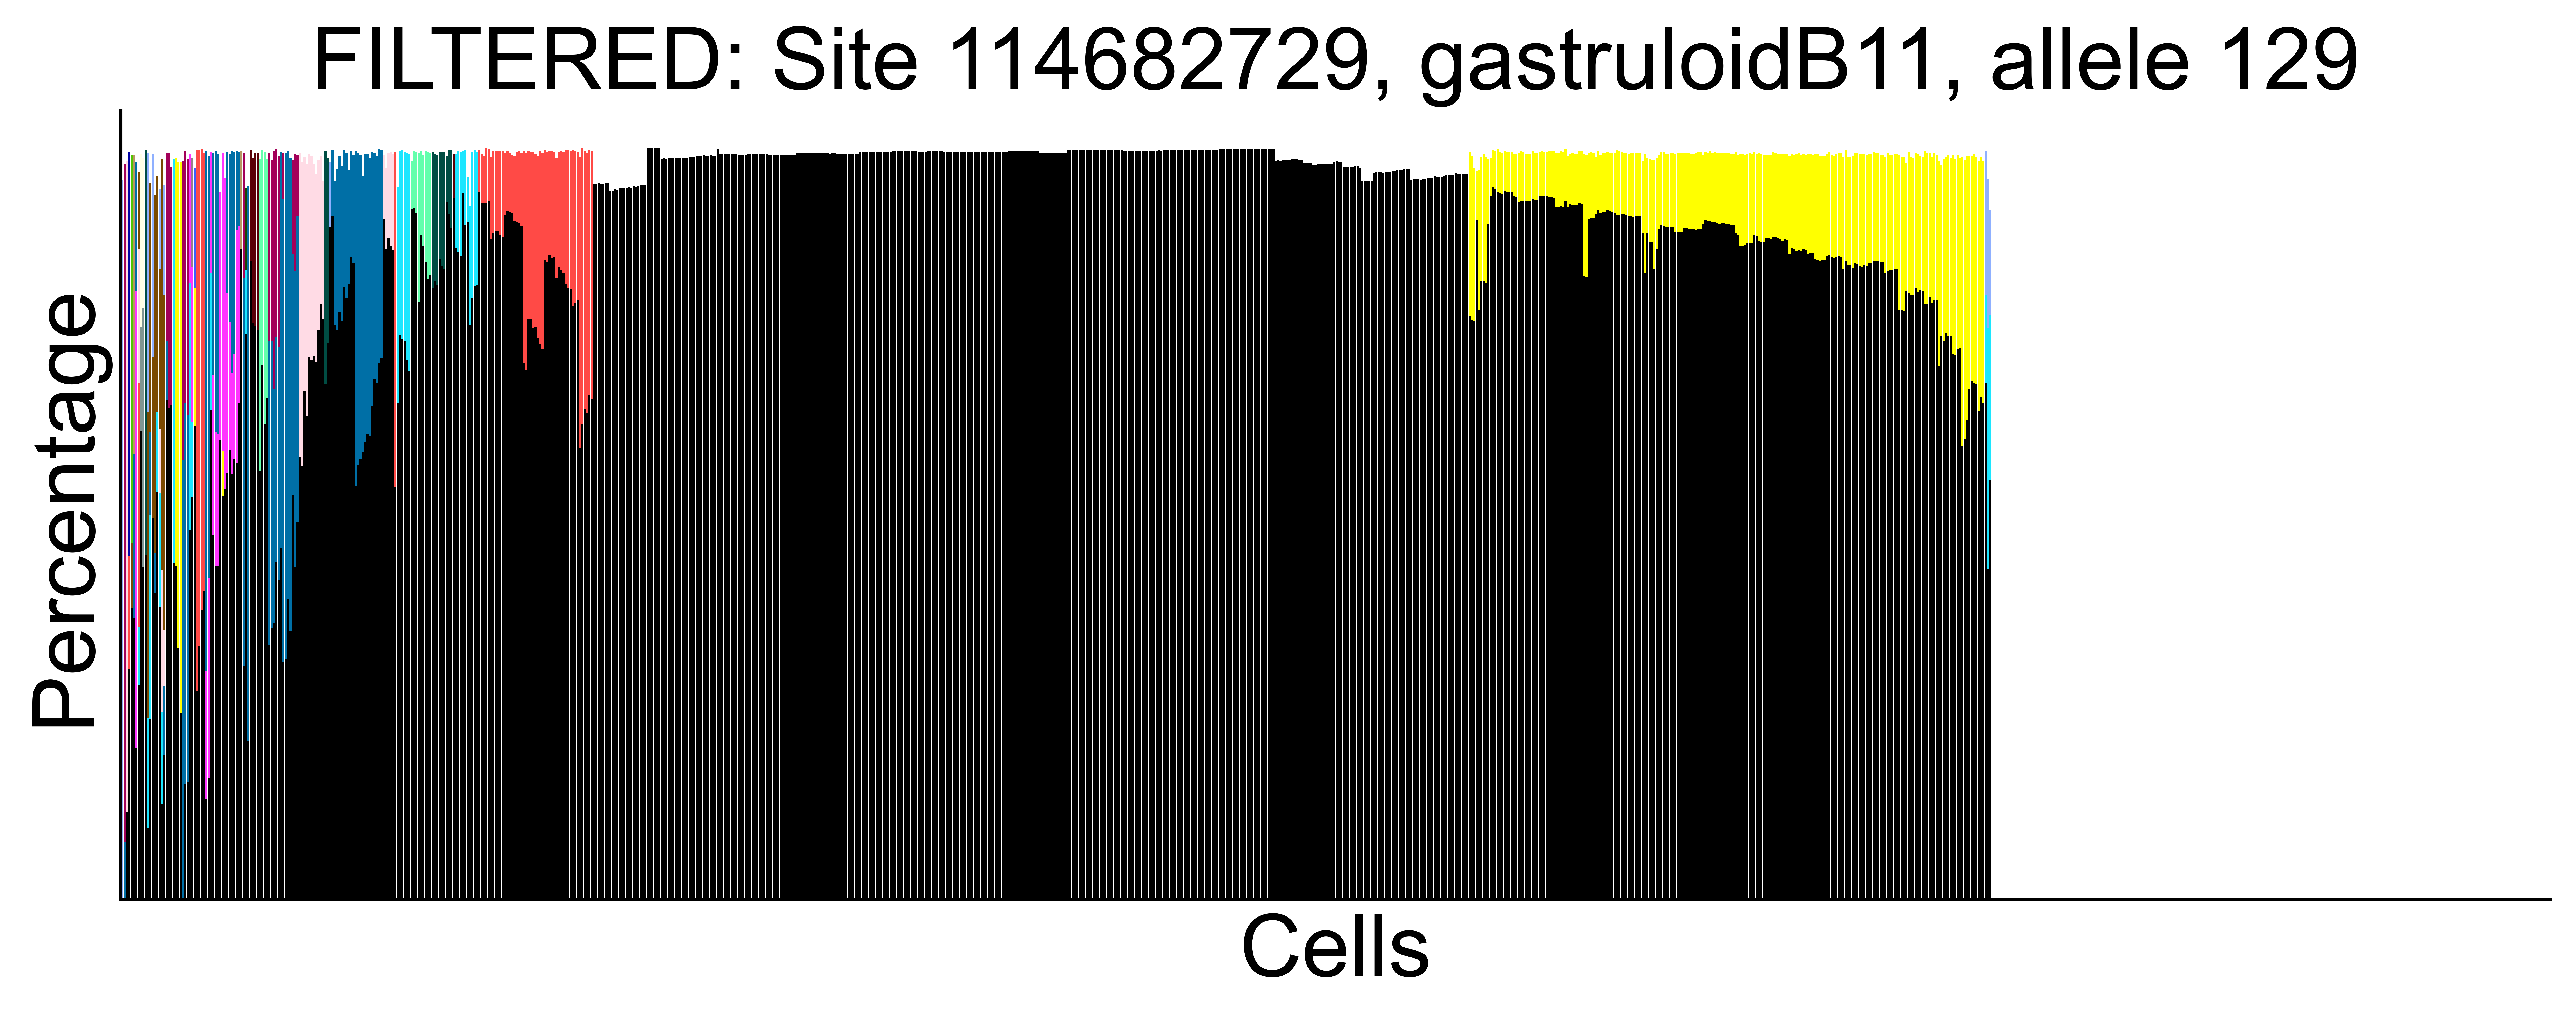

In [19]:
gastruloid = 'B11'
site = 114682729

fontsize = 24

percentagepersite = []
for cell in percentagesChr12_129[gastruloid]:
    percentagepersite.append(percentagesChr12_129[gastruloid][cell][site].dropna())

percentagepersitepd = pd.DataFrame(percentagepersite)

percentagepersitepd = percentagepersitepd.loc[percentagepersitepd.sum(axis = 1).sort_values(ascending=False).index]

order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(percentagepersitepd.fillna(0)))
orderedpercentagepersitepd = percentagepersitepd.iloc[order]
missingvalueslast = pd.concat([orderedpercentagepersitepd[orderedpercentagepersitepd.sum(axis=1) != 0], orderedpercentagepersitepd[orderedpercentagepersitepd.sum(axis=1) == 0]])

ax = missingvalueslast.plot.bar(stacked=True,figsize=(12,4),fontsize = 15,width=0.90, color=cols)


ax.set_xlabel("Cells",fontsize=fontsize)
ax.set_title(('FILTERED: Site ' + str(site) + ', gastruloid' + gastruloid + ', allele 129'), fontsize=fontsize)
ax.set_ylabel("Percentage",fontsize=fontsize)
ax.set_xticks([])
ax.set_yticks([])
ax.legend([],frameon=False)
sns.despine()
#ax.legend(bbox_to_anchor=(0.9,-0.1))



<AxesSubplot:title={'center':'FILTERED: Site 114682729, gastruloidB11, allele 129'}, xlabel='Cells', ylabel='Percentage'>

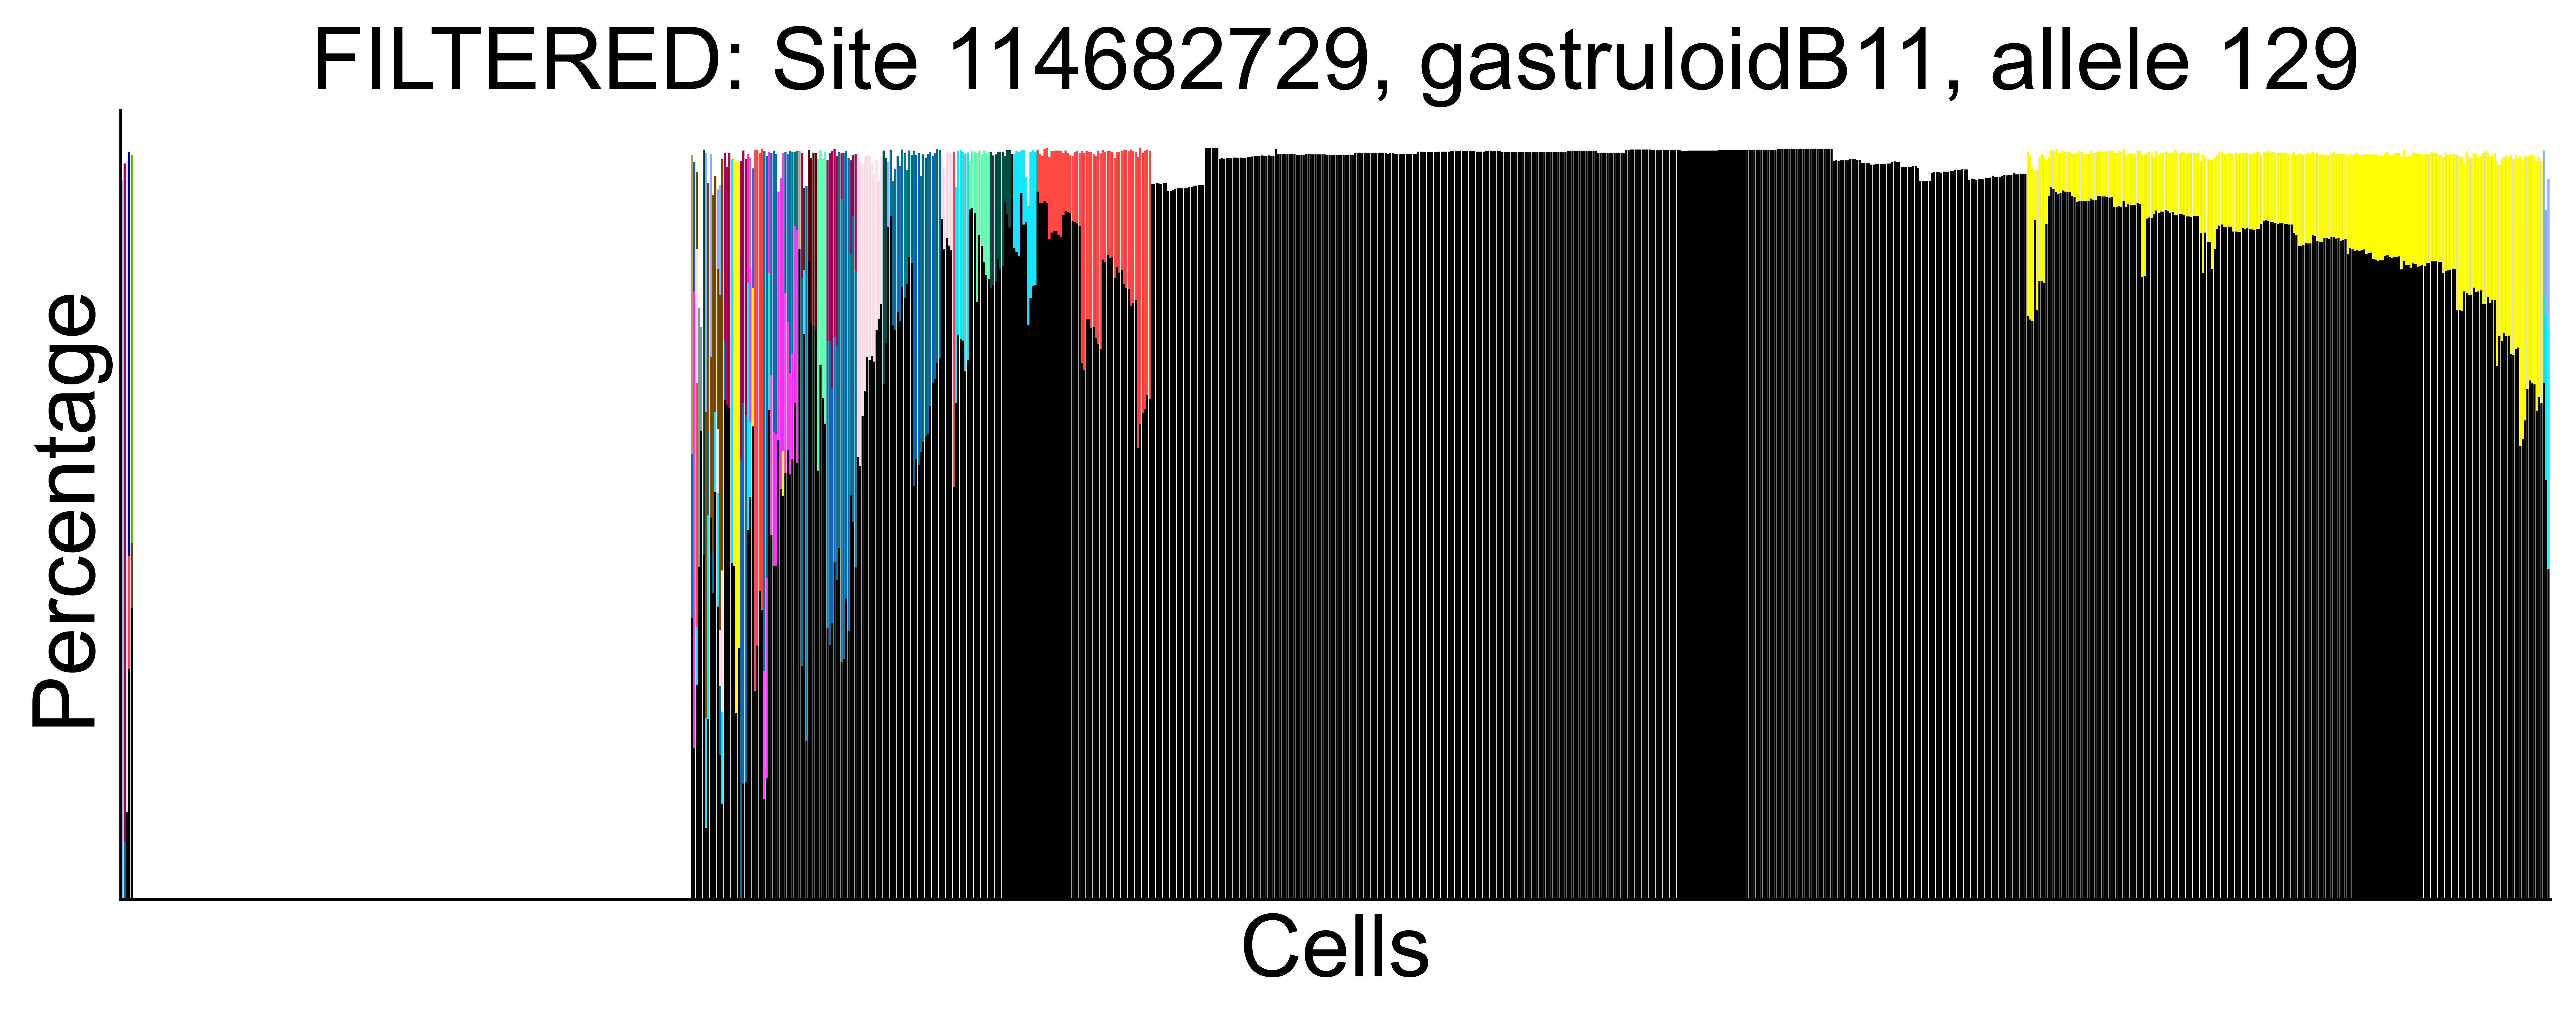

In [20]:
plotPercentagesAllele129('B11',114682729)

# Plotting allele counts

Plot allele counts of scars per cell for one site and all cells of one gastruloid

In [15]:
def plotAlleleCounts129(gastruloid, site):
    allelespersite = []
    fontsize = 24
    for cell in alleleCountsChr12_129PD[gastruloid]:
        allelespersite.append(alleleCountsChr12_129PD[gastruloid][cell][site].dropna())
    allelespersitepd = pd.DataFrame(allelespersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(allelespersitepd.fillna(0)))
    orderedallelepersitepd = allelespersitepd.iloc[order]
    ax = orderedallelepersitepd.plot.bar(stacked=True,figsize=(12,4),fontsize = fontsize,#width=90, 
                                     color=cols)
    ax.set_xlabel("Cells",fontsize= fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('FILTERED: Gastruloid ' + gastruloid +', site ' + str(site) + ', allele 129', fontsize=fontsize)
    ax.set_ylabel("Allele count",fontsize= fontsize)
    #ax.legend(bbox_to_anchor=(1,-0.1))
    ax.legend([],frameon=False)
    sns.despine()
    return ax

def plotAlleleCountsB6(gastruloid, site):
    allelespersite = []
    for cell in alleleCountsChr12_B6PD[gastruloid]:
        allelespersite.append(alleleCountsChr12_B6PD[gastruloid][cell][site].dropna())
    
    allelespersitepd = pd.DataFrame(allelespersite)
    order = scipy.cluster.hierarchy.leaves_list(scipy.cluster.hierarchy.linkage(allelespersitepd.fillna(0)))
    orderedallelepersitepd = allelespersitepd.iloc[order]
    ax = orderedallelepersitepd.plot.bar(stacked=True,figsize=(12,4),fontsize = 30,width=0.90, 
                                     color=cols)
    ax.set_xlabel("Cells",fontsize=80)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('FILTERED: Gastruloid ' + gastruloid +', site ' + str(site) + ', allele B6', fontsize=100)
    ax.set_ylabel("Allele count",fontsize=80)
    #ax.legend(bbox_to_anchor=(1,-0.1))
    ax.legend([],frameon=False)
    return ax

<AxesSubplot:title={'center':'FILTERED: Gastruloid B11, site 114682729, allele 129'}, xlabel='Cells', ylabel='Allele count'>

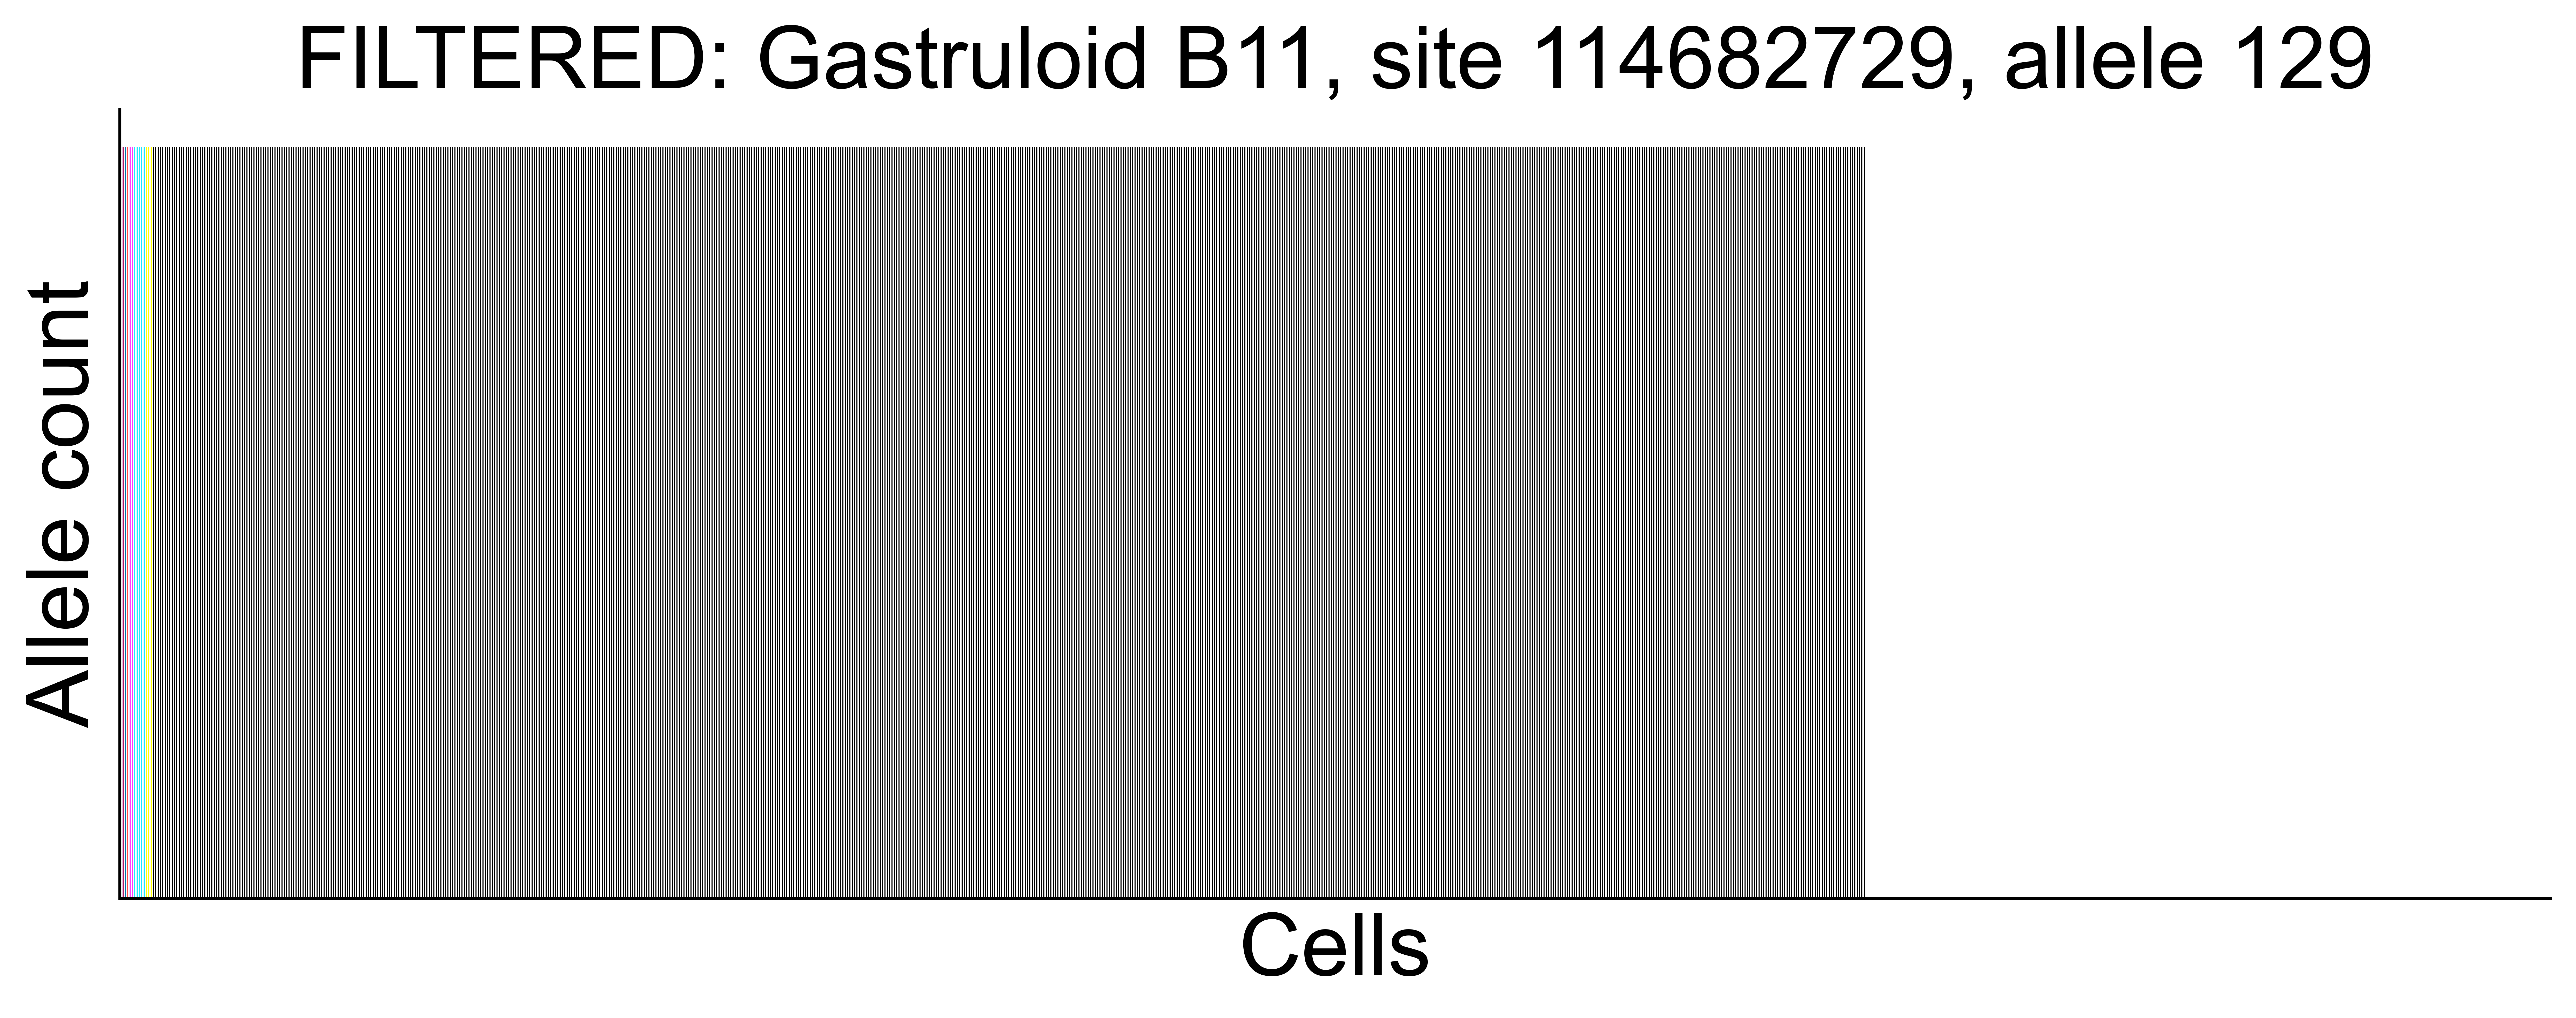

In [23]:
plotAlleleCounts129('B11',114682729)

# 'heatmap' plot - to plot all scars for all sites 

#### We can do an unsupervised selection of sites with high coverage

In [16]:
alleleCounts_all = collections.defaultdict(dict)
for (gastruloid,cell),allSitesInHeatmap in heatmap.T.items():
    for (alleleSite,scar) in allSitesInHeatmap.items():
        if pd.isnull(scar) == False:
            alleleCounts_all[alleleSite][(gastruloid,cell)] = 1

            
alleleCounts_all = pd.DataFrame(alleleCounts_all)

Take top 20 most highly covered sites

In [17]:
list_highCoveredSites = pd.DataFrame(alleleCounts_all.sum().sort_values(ascending=False))
list_highCoveredSites[0:10]

0
129, 114809518  3785.0
129, 114708745  3780.0
129, 114879985  3662.0
129, 114809526  3660.0
129, 114781506  3644.0
129, 114896335  3644.0
129, 114817194  3640.0
B6, 114896335   3614.0
129, 114723869  3584.0
129, 114682729  3506.0

In [18]:
top20 = list_highCoveredSites.index[0:20]

In [19]:
df_targetsites = heatmap[top20]

#### Or we can select known scar sites

Theoretically, all sites:
1. 114682729
2. 114708745
3. 114723869
4. 114736342
5. 114740505
6. 114746370/114746371
7. 114788470
8. 114843748
9. 114851288
10. 114879985
11. 114896335
12. 114910169
13. 114914696


In [20]:
targetsites = ['129, 114682729', 'B6, 114682729', 'nonallelic, 114682729',
                          '129, 114708745', 'B6, 114708745', 'nonallelic, 114708745',
                          '129, 114723869', 'B6, 114723869', 'nonallelic, 114723869',
                          '129, 114736342', 'B6, 114736342', 'nonallelic, 114736342',
                          '129, 114740505', 'B6, 114740505', 'nonallelic, 114740505',
                          '129, 114746370', 'B6, 114746370', 'nonallelic, 114746370',
                          '129, 114788469', 'B6, 114788469', 'nonallelic, 114788469',
                          '129, 114843748', 'B6, 114843748', 'nonallelic, 114843748',
                          '129, 114851288', 'B6, 114851288', 'nonallelic, 114851288',
                          '129, 114879985', 'B6, 114879985', 'nonallelic, 114879985',
                          '129, 114896335', 'B6, 114896335', 'nonallelic, 114896335',
                         '129, 114910169', 'B6, 114910169', 'nonallelic, 114910169',
                         '129, 114914696', 'B6, 114914696', 'nonallelic, 114914696']

In [21]:
found_targetsites = []
for site in targetsites:
    if 'nonallelic' not in site:
        if site in heatmap.columns:
            found_targetsites.append(site)

In [22]:
found_targetsites

['129, 114682729',
 'B6, 114682729',
 '129, 114708745',
 'B6, 114708745',
 '129, 114723869',
 'B6, 114723869',
 '129, 114736342',
 'B6, 114736342',
 '129, 114740505',
 'B6, 114740505',
 '129, 114746370',
 'B6, 114746370',
 '129, 114788469',
 'B6, 114788469',
 '129, 114843748',
 'B6, 114843748',
 '129, 114851288',
 'B6, 114851288',
 '129, 114879985',
 'B6, 114879985',
 '129, 114896335',
 'B6, 114896335',
 '129, 114914696',
 'B6, 114914696']

In [23]:
df_targetsites = heatmap[found_targetsites] 
df_targetsites

129, 114682729 B6, 114682729 129, 114708745  \
gastruloid cell                                                 
A8         Q1_1               WT            WT             WT   
           Q1_10              WT           NaN             WT   
           Q1_100             WT            WT             WT   
           Q1_101            NaN            WT            NaN   
           Q1_102             WT            WT             WT   
...                          ...           ...            ...   
C1         Z1_95              WT            WT             WT   
           Z1_96              WT            WT             WT   
           Z1_97             NaN            WT             WT   
           Z1_98              WT           NaN            NaN   
           Z1_99              WT            WT             WT   

                                                       B6, 114708745  \
gastruloid cell                                                        
A8         Q1_1                                                  NaN   
           Q1_10   114708792.D,114708793.D,114708794.D,114708795....   
           Q1_100  114708792.D,114708793.D,114708794.D,114708795....   
           Q1_101  114708792.D,114708793.D,114708794.D,114708795....   
           Q1_102  114708792.D,114708793.D,114708794.D,114708795....   
...                                                              ...   
C1         Z1_95                                                 NaN   
           Z1_96                                                 NaN   
           Z1_97   114708792.D,114708793.D,114708794.D,114708795....   
           Z1_98                                                 NaN   
           Z1_99                                                 NaN   

                                                      129, 114723869  \
gastruloid cell                                                        
A8         Q1_1                                                   WT   
           Q1_10                                                  WT   
           Q1_100                                                 WT   
           Q1_101                                                NaN   
           Q1_102                                                 WT   
...                                                              ...   
C1         Z1_95                                                  WT   
           Z1_96                                                  WT   
           Z1_97   114723925.D,114723926.D,114723927.D,114723928....   
           Z1_98                                                  WT   
           Z1_99                                                  WT   

                                                       B6, 114723869  \
gastruloid cell                                                        
A8         Q1_1                                                  NaN   
           Q1_10                                                  WT   
           Q1_100                                                 WT   
           Q1_101                                                NaN   
           Q1_102                                                 WT   
...                                                              ...   
C1         Z1_95                                                  WT   
           Z1_96                                                  WT   
           Z1_97   114723923.D,114723924.D,114723925.D,114723926....   
           Z1_98                                                 NaN   
           Z1_99                                                 NaN   

                  129, 114736342 B6, 114736342 129, 114740505 B6, 114740505  \
gastruloid cell                                                               
A8         Q1_1              NaN           NaN            NaN            WT   
           Q1_10             NaN           NaN            NaN            WT   
           Q1_100            NaN           Na

Some quality checks

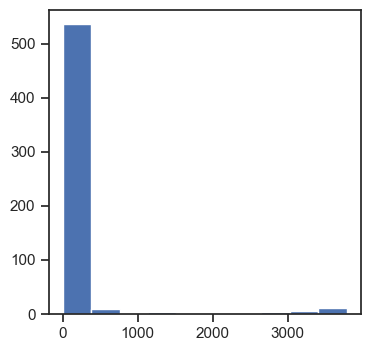

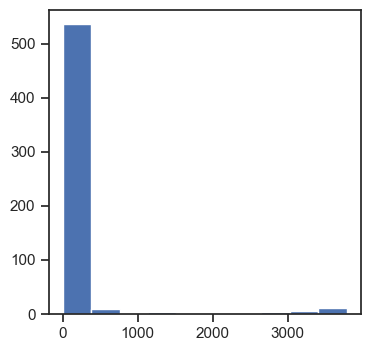

In [24]:
# Select sites with plenty of data:
plt.hist( (~pd.isnull(heatmap)).sum() )
plt.show()
df_selected = heatmap.loc[:, ((~pd.isnull(heatmap)).sum()>150) ]
plt.hist( (~pd.isnull(heatmap)).sum() )
plt.show()


In [25]:
## For the full dataset, not separated for each gastruloid yet
# define the total amount of scars
totalScars = set()
for i,r in df_targetsites.iterrows():
    totalScars.update( set( [x for x in r.unique() if not pd.isnull(x)]) )


In [26]:
## For the full dataset, not separated for each gastruloid yet
# define one colour for each scar
cmap = plt.get_cmap('hsv')
scarColors = { scar: cmap(x) for scar, x in zip(totalScars, np.linspace(0,1, len(totalScars))) }
scarColors['WT'] = (0,0,0)

In [27]:
# Determine organisation of the plot, based on site-allele with most information
df_targetsites = df_targetsites.sort_values([df_targetsites.columns[0],df_targetsites.columns[1]])


In [28]:
df_targetsites = df_targetsites[(~pd.isnull(df_targetsites)).sum(axis=1)>0]


### Rows are cells and columns are sites-alleles. Plots are made for the full dataset or for each gastruloid separately.

In [29]:
def plotHeatmap(df, figsize = (15,50)):
    fig, ax = plt.subplots(1, figsize=figsize)
    columnsCount = df.shape[1]
    
    rowHeight = 1
    rowColwidth = 1
    rowSpacing = 0.3
    for cellIndex, (cellName, row) in enumerate(df.iterrows()):
        for columnIndex,column in enumerate(df.columns):
            scarForThisCell = row[column]
            if not pd.isnull(scarForThisCell):
                ax.add_patch(
                matplotlib.patches.Rectangle(
                    (rowColwidth*columnIndex,rowHeight*cellIndex ), 
                    rowColwidth, rowHeight-rowSpacing, color= scarColors[scarForThisCell])
            )

    ax.set_ylim(0,rowHeight*(df.shape[0]+1))
    ax.set_xlim(0,rowColwidth*(df.shape[1]))
    ax.set_xticks([columnIndex+0.5 for columnIndex,column in enumerate(df.columns)])
    ax.set_xticklabels([column for columnIndex,column in enumerate(df.columns)],rotation=90)
    ax.set_yticks([cellIndex+0.5 for cellIndex,cellName in enumerate(df.index)])
    ax.set_yticklabels([cellName for cellIndex,cellName in enumerate(df.index)],fontsize=6.5)

    return ax

To plot all sites, all gastruloids:

In [30]:
pathToSaveData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20200511_AllScarData_Remapped_MaskedRef_alteredAlleles/120hAA_VAN2988_SQ98/figures/filtered/'

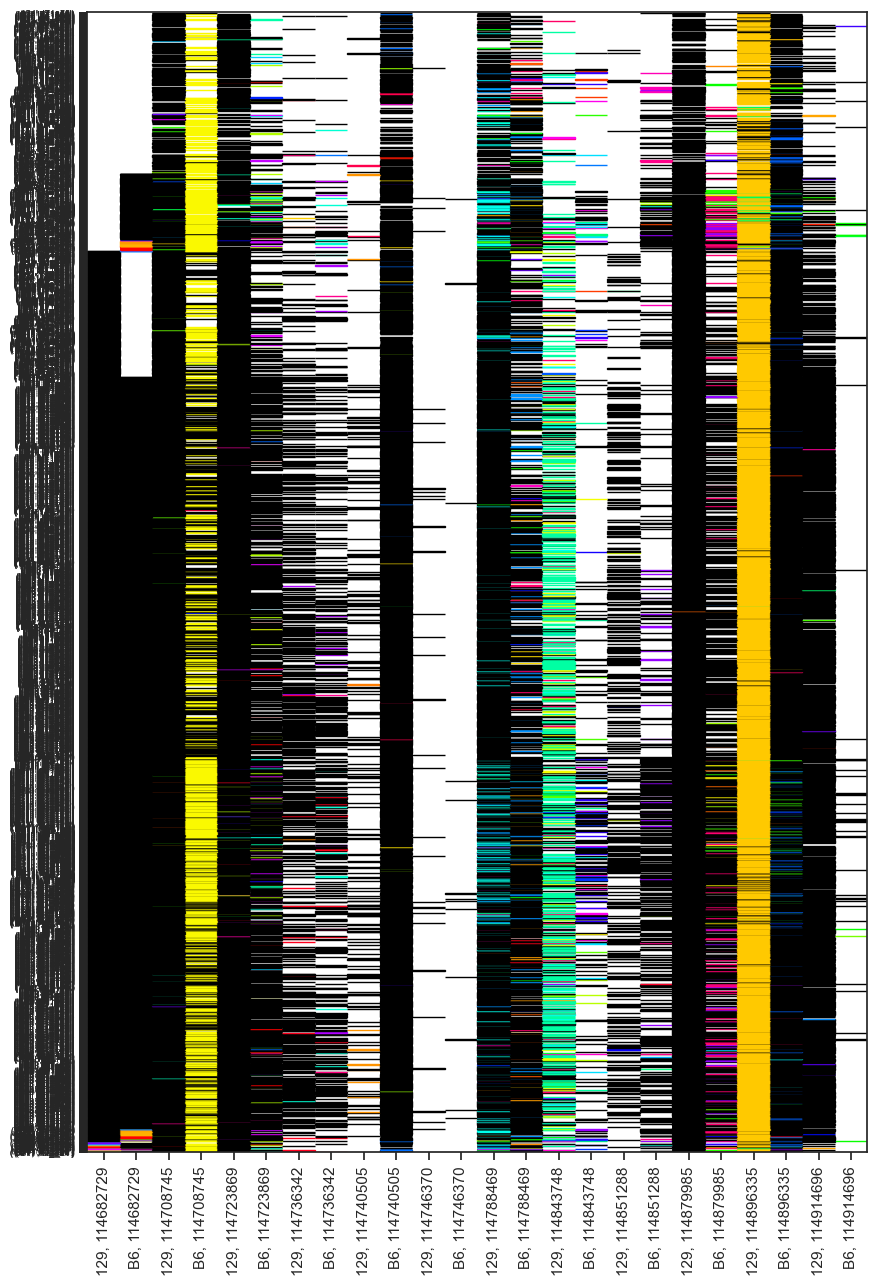

In [31]:
plotheatmap = plotHeatmap(df_targetsites, (10,15))
fig = plotheatmap.get_figure()
fig.savefig(pathToSaveData + 'heatmap_all.png',dpi=dpi)

# Clustering using Information Weighted Sparse Sample Distance (IWSS)

In [32]:
all_allelecounts_fordistancecalc.columns.levels[0]

Index(['A8', 'B11', 'B8', 'C1'], dtype='object')

In [33]:
all_allelecounts = all_allelecounts_fordistancecalc.fillna(0).transpose()
# to check scars only, no WT counts
all_allelecounts_noWT = all_allelecounts[all_allelecounts.columns.drop(list(all_allelecounts.filter(regex='WT')))]

In [34]:
#sns.set_style('white')
def plotAllAlleleCounts(allelecounts, bins=20,color='black', title = 'Number of scars per cell'):
    plt.figure(figsize=(4,4))
    sns.set_context('talk')
    sns.set_style('ticks')
    sns.histplot(allelecounts.sum(axis=1), bins = bins, color = color)
    #allelecounts.sum(axis=1).plot.hist(grid=True, bins=bins, rwidth=0.95,color=color)
    plt.xlabel('Number of scars')
    plt.title(title)
    plt.ylabel('Number of cells')
    sns.despine()

In [35]:
all_allelecounts.sum(axis = 1).mean()

13.063900599068116

In [36]:
all_allelecounts_noWT.sum(axis = 1).mean()

1.6378966052806745

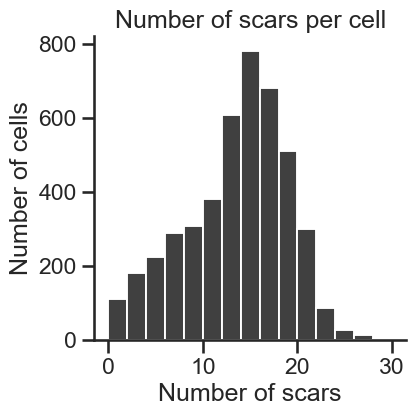

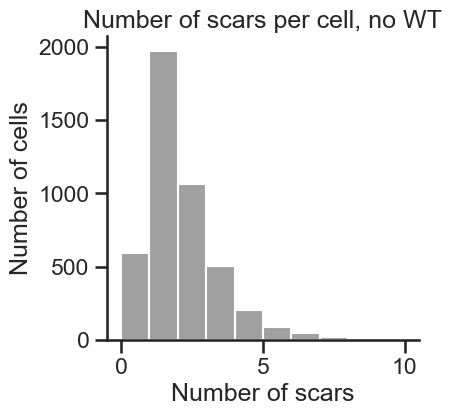

In [37]:
plotAllAlleleCounts(all_allelecounts, bins = 15)
plotAllAlleleCounts(all_allelecounts_noWT, bins=10,color='grey', title = 'Number of scars per cell, no WT')

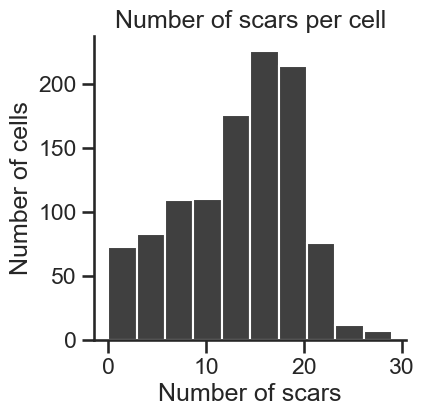

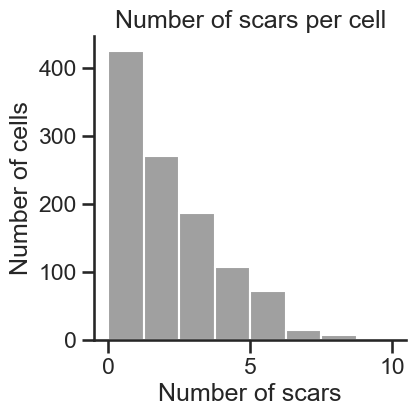

In [38]:
plotAllAlleleCounts(all_allelecounts.loc['B11'], bins = 10)
plotAllAlleleCounts(all_allelecounts_noWT.loc['B11'], bins=8,color='grey')

In [39]:
#this filters out cells with less than n counts
filtered_all_allelecounts = collections.defaultdict(dict)
for cell in all_allelecounts.index:
    if all_allelecounts.loc[cell].sum() > 2:
        filtered_all_allelecounts[cell] = all_allelecounts.loc[cell]
filtered_all_allelecountsPD = pd.DataFrame.from_dict(filtered_all_allelecounts).transpose()

filter_allelecountsB11 = filtered_all_allelecountsPD.loc['B11'].fillna(0)
filter_allelecountsB8 = filtered_all_allelecountsPD.loc['B8'].fillna(0)
filter_allelecountsA8 = filtered_all_allelecountsPD.loc['A8'].fillna(0)
filter_allelecountsC1 = filtered_all_allelecountsPD.loc['C1'].fillna(0)

filter_all_allelecounts = filtered_all_allelecountsPD.fillna(0).transpose()

# Distance matrix for all gastruloids

distanceMatrix automatically returns the figure of the clustering. In addition, when saying x = distanceMatrix(dataframe), it assigns the output (distance) matrix df to x. This can later be used for clustering the data into groups.

In [40]:
def distanceMatrix(filteredDF,figsize=(15,15),heatmapTitle=''):
    rawMatrix = filteredDF.values 
    rawMatrix = rawMatrix[:, np.logical_and( 
        np.sum(rawMatrix==0,axis=0)>0,
        np.sum(rawMatrix==1,axis=0)>0)]
    pOnes = []
    pZeros = []
    for i in range(rawMatrix.shape[1]):
    # Weights:
        column = rawMatrix[:,i]
        pOnes.append( -np.log2( ( np.sum(column==1)/len(column) )**2 ) ) #probability of two cells both having sSNV
        pZeros.append( -np.log2( ( np.sum(column==0)/len(column) )**2 ) )#probability of two cells not having sSNV,  (and we know it)
    pOnes = np.array(pOnes)
    pZeros = np.array(pZeros)
    
    print( np.sum( np.logical_not(np.isfinite(pZeros)) ),  np.sum((np.isfinite(pZeros))))
    print( np.sum( np.logical_not(np.isfinite(pOnes)) ),  np.sum((np.isfinite(pOnes))))
    print(rawMatrix.shape)
    
    jointMatrix = np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )
    simMatrix =  np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )
    differenceMatrix =  np.zeros( (rawMatrix.shape[0], rawMatrix.shape[0]) )

    for cai in range(rawMatrix.shape[0]):
        for cbi in range(rawMatrix.shape[0]):
            
        
                # Un normalized distance
            pairwiseUnnormalizedDistance = np.logical_and( rawMatrix[cai,:]==1, rawMatrix[cbi,:]==0 ) * \
            (pOnes + pZeros) + \
            np.logical_and( rawMatrix[cai,:]==0, rawMatrix[cbi,:]==1 ) * (pZeros + pOnes) # For different batches the pOnes/pZeros is batch depended

                # Normalize the distance:
            normalisationFactor = np.sum( pOnes* (rawMatrix[cai,:]==1)) + np.sum( pZeros*(rawMatrix[cai,:]==0)) + \
            np.sum( pOnes* (rawMatrix[cbi,:]==1)) + np.sum( pZeros* (rawMatrix[cbi,:]==0))

            pairwiseNormalizedDistance = np.sum(pairwiseUnnormalizedDistance) / (
                        normalisationFactor )
            differenceMatrix[cai, cbi] = pairwiseNormalizedDistance

                # Similarity calculation:
            sim = np.sum( (pOnes+pOnes) * np.logical_and( rawMatrix[cai,:]==1, rawMatrix[cbi,:]==1 )) + \
                      np.sum( (pZeros+pZeros)*np.logical_and( rawMatrix[cai,:]==0, rawMatrix[cbi,:]==0 ))

            normalisedSim = sim/normalisationFactor
            simMatrix[cai, cbi] = normalisedSim

            joinedDistance =  pairwiseNormalizedDistance + (1-normalisedSim )
            jointMatrix[cai,cbi]= joinedDistance


            if cai==cbi:
                break

    normalisedSim, normalisationFactor, sim, rawMatrix[cai,rawMatrix[cai,:]>=0], rawMatrix[cbi,rawMatrix[cbi,:]>=0]
    print(np.where( np.logical_not( np.isfinite( jointMatrix ) ) ))
    #rawMatrix[ np.where( np.logical_not( np.isfinite( jointMatrix ) ) )[0][0] ]
    
    for i in range(jointMatrix.shape[0]):
        for j in range(jointMatrix.shape[0]):
            jointMatrix[j,i]=jointMatrix[i,j]
            if i==j:
                break

    df = pd.DataFrame( np.log(jointMatrix+1), index=filteredDF.index, columns=filteredDF.index )
    x = sns.clustermap( df, vmin=0,vmax=1, figsize=figsize, method='average',metric='euclidean')
    x.fig.suptitle(heatmapTitle)
    x.fig.subplots_adjust(top=0.93)
    #.savefig('heatmapC5F10.png',dpi=300)
    return df
    



## All gastruloids from dataset
 B11, B8, A8, C1

0 152
0 152
(1013, 152)
(array([], dtype=int64), array([], dtype=int64))


/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


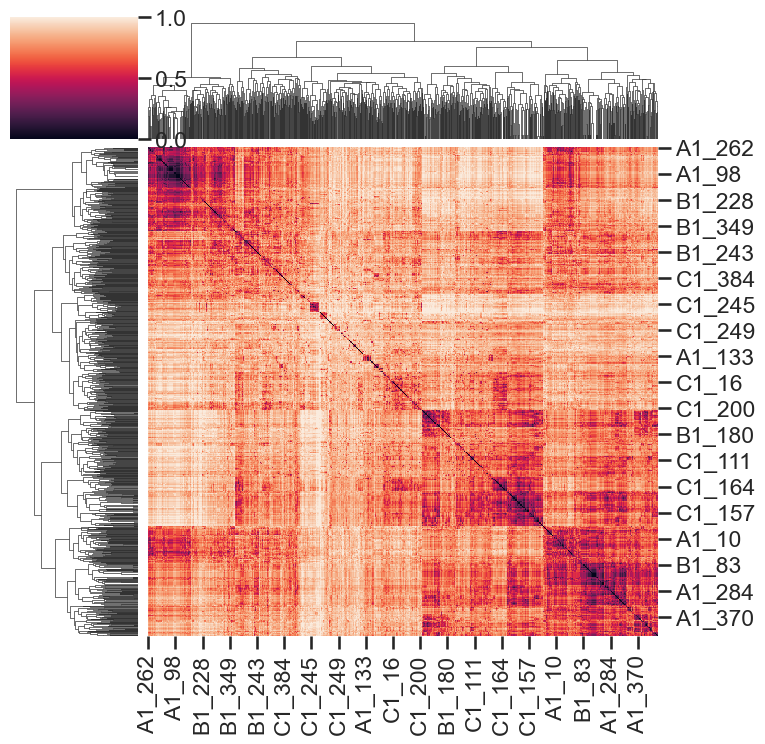

In [41]:
dmB11 = distanceMatrix(filter_allelecountsB11, figsize = (8,8))

0 114
0 114
(1087, 114)
(array([], dtype=int64), array([], dtype=int64))


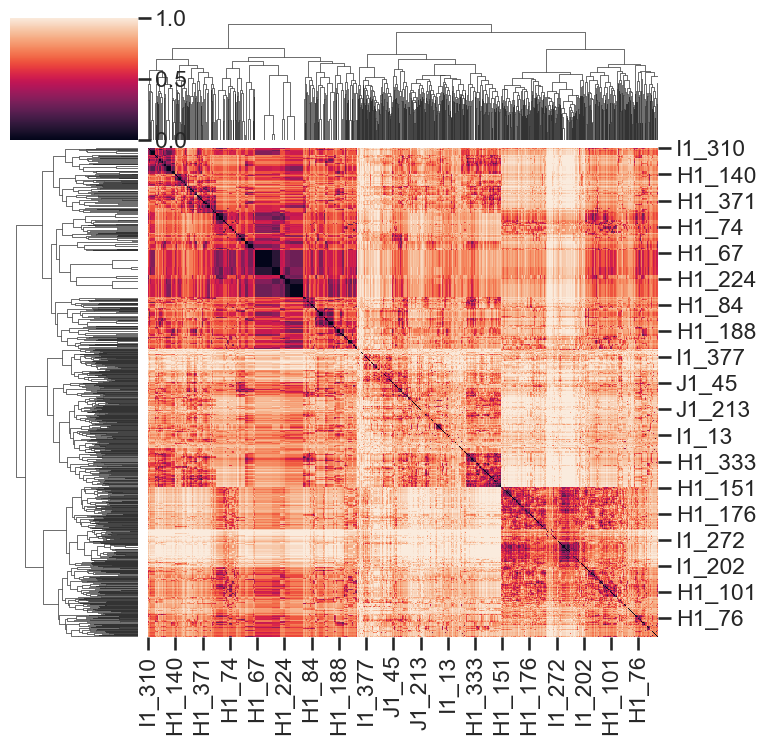

In [42]:
dmB8 = distanceMatrix(filter_allelecountsB8, figsize = (8,8))

0 164
0 164
(1142, 164)
(array([], dtype=int64), array([], dtype=int64))


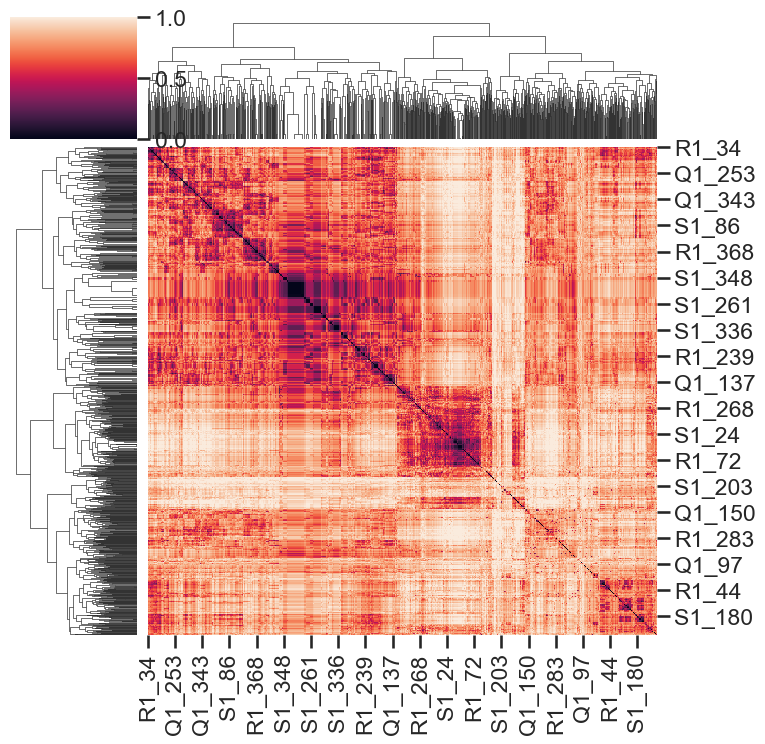

In [43]:
dmA8 = distanceMatrix(filter_allelecountsA8, figsize = (8,8))

0 114
0 114
(1066, 114)
(array([], dtype=int64), array([], dtype=int64))


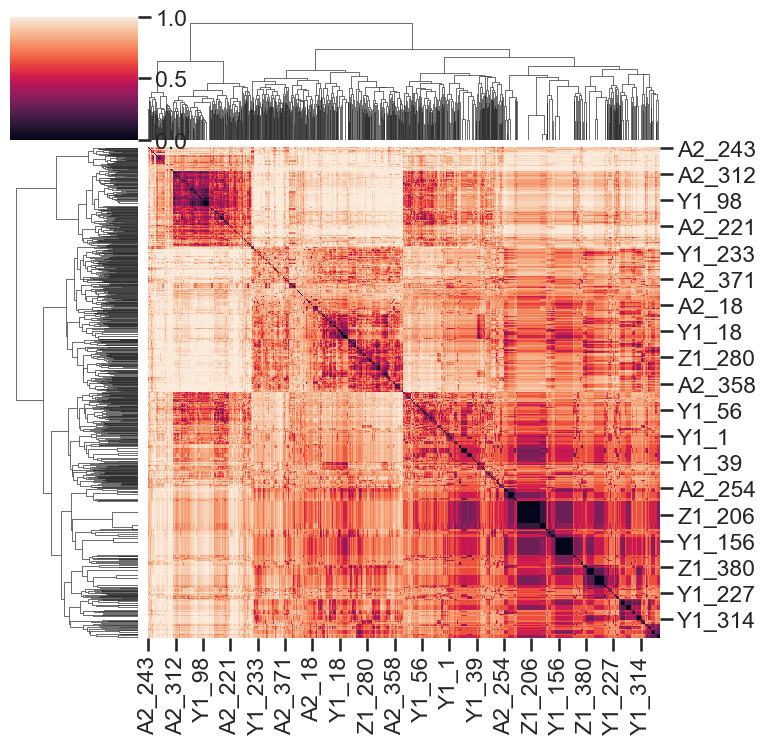

In [44]:
dmC1 = distanceMatrix(filter_allelecountsC1, figsize = (8,8))

In [45]:
all_allelecounts_fordistancecalc.columns.levels[0]

Index(['A8', 'B11', 'B8', 'C1'], dtype='object')

## Clustering based on computed distance matrix.

In [46]:
def scipyClustering(df, gastruloidName = '', clusterNumber = 20):
    x = scipy.cluster.hierarchy.linkage(df.fillna(0),'ward')
    clusters = scipy.cluster.hierarchy.cut_tree(x, n_clusters= (clusterNumber))
    clust = pd.DataFrame.from_dict({cellName:{('clust_' + gastruloidName):clusters[cellIndex][0]} for cellIndex,cellName in enumerate(df.index)}).transpose()
    return clust

In [48]:
B11_clust = scipyClustering(dmB11, gastruloidName = 'B11',  clusterNumber = (len(dmB11)/10))

In [49]:
B8_clust = scipyClustering(dmB8, gastruloidName = 'B8',  clusterNumber = (len(dmB8)/10))

In [50]:
A8_clust = scipyClustering(dmA8, gastruloidName = 'A8',  clusterNumber = (len(dmA8)/10))

In [51]:
C1_clust = scipyClustering(dmC1, gastruloidName = 'C1',  clusterNumber = (len(dmC1)/10))